In [105]:
from pruneshift.datamodules import ShiftDataModule
from pruneshift.networks import create_network
from pruneshift.teachers import create_teacher
from pruneshift.teachers import Teacher
from crd.criterion import CRDLoss
from torch.utils.data import DataLoader

from torchvision.datasets import ImageFolder

import random
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import torch
import os
import numpy as np
from pytorch_lightning.metrics.functional import accuracy


img100_path = "/misc/scratchSSD2/datasets/ILSVRC2012-100/train"
amda_path = "/misc/lmbraid19/hoffmaja/models/imagenetr_models/deepaugment_and_augmix.pth.tar"
data_swsl_path = "/misc/lmbraid19/hoffmaja/data_swsl_resnet50.pt"
data_amda_path = "/misc/lmbraid19/hoffmaja/data_amda_resnet50.pt"
data_std_path = "/misc/lmbraid19/hoffmaja/data_standard_resnet50.pt"

In [ ]:
data_amda = create_teacher(num_classes=100, activations_path=data_amda_path, imagenet_subset=True)
data_swsl = create_teacher(num_classes=100, activations_path=data_swsl_path, imagenet_subset=True)

In [ ]:
dm_train = ShiftDataModule("imagenet", path)
dm_train.setup("fit")

In [84]:
class SoftProbDataset:
    def __init__(self, activations_path, T, dataset_path=img100_path):
        self.dataset = ImageFolder(dataset_path)
        self.activations = create_teacher(num_classes=100, activations_path=activations_path, imagenet_subset=True)
        self.T = T
        
    def __getitem__(self, idx):
        label = self.dataset.targets[idx]
        pred = self.activations(torch.tensor(idx), None)
        probs = torch.softmax(pred / self.T, 0)
        
        return label, probs[label], probs.max()

    def __len__(self):
        return len(self.dataset)

In [93]:
def calculate_probs_distr(loader, num_bins=100):
    bins = np.linspace(0, 1, num_bins)
    counts = np.zeros(shape=len(bins) - 1, dtype=np.int64)
    for _, probs, _ in loader:
        partial_counts, _ = np.histogram(probs.numpy(), bins)
        counts += partial_counts

    return bins, counts

def plot_probs_distr(**loaders):
    for name, loader in loaders.items():
        bins, counts = calculate_probs_distr(loader)
        bin_positions = (bins[1: ] + bins[: -1]) / 2
        plt.bar(bin_positions, counts, width=1/99, alpha=0.5, label=name)
    plt.legend()

In [114]:
dataset_swsl = SoftProbDataset(data_swsl_path, 5)
loader_swsl = DataLoader(dataset_swsl, batch_size=256, num_workers=3)

In [112]:
dataset_amda = SoftProbDataset(data_amda_path, 4)
loader_amda = DataLoader(dataset_amda, batch_size=256, num_workers=3)

In [109]:
dataset_std = SoftProbDataset(data_std_path, 4)
loader_std = DataLoader(dataset_std, batch_size=256, num_workers=3)

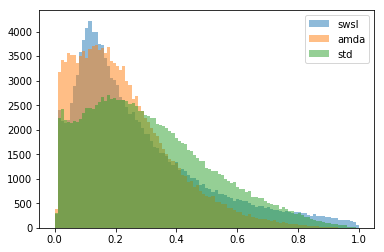

In [115]:
plot_probs_distr(swsl=loader_swsl, amda=loader_amda, std=loader_std)

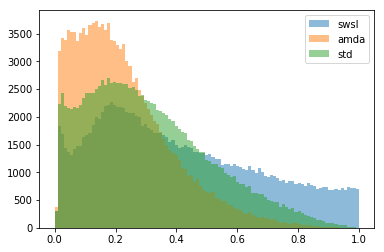

In [107]:
# T = 4
plot_probs_distr(swsl=loader_swsl, amda=loader_amda, std=loader_std)

<BarContainer object of 99 artists>

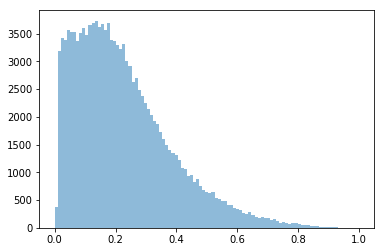

In [77]:
bin_positions = (bins[1: ] + bins[: -1]) / 2
plt.bar(bin_positions, counts, width=1/99, alpha=0.5)

In [72]:
counts

array([ 382, 3185, 3413, 3383, 3557, 3526, 3528, 3370, 3503, 3601, 3470,
       3649, 3698, 3733, 3623, 3668, 3563, 3686, 3394, 3368, 3292, 3227,
       3305, 2999, 2909, 2623, 2692, 2483, 2374, 2241, 2147, 2031, 1928,
       1879, 1726, 1598, 1500, 1407, 1356, 1321, 1218, 1081, 1059,  940,
        945,  830,  871,  760,  687,  641,  624,  639,  532,  527,  490,
        479,  409,  411,  355,  330,  312,  266,  249,  288,  230,  202,
        184,  186,  176,  169,  144,  156,  116,   93,  109,   88,   71,
         82,   78,   64,   47,   49,   43,   34,   29,   31,   21,   21,
         12,    9,    9,    7,    5,    4,    5,    0,    0,    0,    1])